# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 4.51 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Russian.txt', './data/Names/Dutch.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdulkadyroff', 

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Russian': ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdu

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [12]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [13]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        # final compnents
        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        # forget gate
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forget gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [14]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [15]:
print(all_categories)

['Russian', 'Dutch', 'Japanese', 'Arabic', 'Chinese', 'Vietnamese', 'Italian', 'Korean', 'Polish', 'Czech', 'German', 'Greek', 'Irish', 'Spanish', 'English', 'French', 'Portuguese', 'Scottish']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [16]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Dutch 
 word = Meeuweszen 
 category_tensor = tensor([1]) 
 word_tensor = tensor([10, 13, 13, 55, 46, 13, 19, 34, 13, 54]) 
 len word_tensor = torch.Size([10])


category = Japanese 
 word = Sugitani 
 category_tensor = tensor([2]) 
 word_tensor = tensor([27, 55, 57,  9, 80, 73, 54,  9]) 
 len word_tensor = torch.Size([8])


category = Spanish 
 word = Ibarra 
 category_tensor = tensor([13]) 
 word_tensor = tensor([ 4, 75, 73, 78, 78, 73]) 
 len word_tensor = torch.Size([6])


category = Arabic 
 word = Assaf 
 category_tensor = tensor([3]) 
 word_tensor = tensor([56, 19, 19, 73, 47]) 
 len word_tensor = torch.Size([5])


category = Dutch 
 word = Reijnder 
 category_tensor = tensor([1]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Training the Network
 In the following change the initialisation with the model you want to use.




In [17]:
n_hidden = 128
criterion = nn.NLLLoss()

In [18]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')

In [19]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds')

In [20]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3.1
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

## Answer
It is happening that the loss goes to NAN values, indeed the problem that we are experiencing in this case is the so called **exploding gradient problem**. Th epoint is that the RNN backbone has the drawback that the closer I move to the end of the sequence of inputs the more I have to add and to multiply the weights of my network. So during the training the graduient might *vanishing* or *exploding* like in this case, so it means that I will not learn lonmg term dependencies.

\begin{equation}
A_t = \Theta_cA_{t-1} + \Theta_xx_t
\end{equation}

Let's consider the recurrence on the hidden space and forget the input
\begin{equation}
 A_t = \Theta_cA_{t-1}
\end{equation}

\begin{equation}
\begin{aligned}
A_1 &= \Theta_cA_0\\
A_2 &= \Theta_cA_1 = \Theta_c(\Theta_cA_0) = \Theta_c^2A_0\\
A_3 &= \Theta_cA_2 = \Theta_c(\Theta_cA_1) = \Theta_c(\Theta_c(\Theta_cA_0)) = \Theta_c^3A_0\\
...\\
A_t &= \Theta_c^tA_0 \quad \text{the parameters are muiltiplied t times}
\end{aligned}
\end{equation}




# Question 3.2
What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.
## Answer
The quickest way to get rid of the problem is to modify the code inserting the **gradient clipping**.

Let's $g = \frac{\partial\mathcal{L}}{\partial \Theta_c}$ are the gradeitns of the loss $\mathcal{L}$ with respect to the model's parameters $\Theta_c$

If $||g|| \leq c$ then $g = c \cdot \frac{g}{||g||}$, this ensure that I have no longer strong weights since I make the norm of $g$ maximum of $c$ . Indeed this helps the gradient descent to have a resonabe behaviour even if the loss landscape of the model is irregular.

# Question 3.2
What is the other problem this kind of network has? And what are the possible solutions?
## Answer
The architecture have multiple drowbacks but the main two are the following one:
1. **Limited Contextual Information**: RNNs have a limited ability to capture long-range dependencies in sequences. This is because they suffer from the vanishing gradient problem, which hampers their ability to retain information over many time steps.
2. **Difficulty Learning Long-Term Dependencies**: RNNs find it challenging to learn dependencies that are separated by a large number of time steps. This limits their ability to capture long-term dependencies in sequences. For example given a sequence of words the information of the first word that is kept at the last input is very insignificant respect to the last input word.

One of the possible soluton is to is to switch to an LSTM architecture. The LSTM has the following main advantages respect to a classical RNN:
1. **Gating Structure**: LSTMs incorporate a gating mechanism that consists of input, forget, and output gates. These gates control the information flow, allowing the network to decide what information to keep or forget at each time step.
2. **Long-Term Dependency Handling**: LSTMs are designed to address the vanishing gradient problem, allowing them to capture long-term dependencies. This is achieved through the use of a gating mechanism that regulates the flow of information through the cell state whoch as the main goal to retain the long term memory.
3. **Reduced Vanishing Gradient**: The architecture of LSTMs reduces the vanishing gradient problem, making possible tocapture long term dependencies through the all input sequence.

In [21]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):
    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):

      output, h = model(word_tensor[i], h)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Gradient clipping using that clips the gradients using a vector norm
    # Clips gradient norm of an iterable of parameters.
    #The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

    # Basic Gradient Clipping
    torch.nn.utils.clip_grad_value_(model.parameters(), 1.)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [22]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []


  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [23]:
optimizer_rnn = optim.SGD(rnn.parameters(), lr = 0.005)
#optimizer_rnn = optim.Adam(rnn.parameters(), lr = 0.005)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 10s) 2.8467 Praseta / Spanish NO (Czech)
10000 10% (0m 20s) 1.5097 Rhee / Chinese NO (Korean)
15000 15% (0m 29s) 4.7163 Donk / Korean NO (Dutch)
20000 20% (0m 39s) 1.8956 John / Korean NO (Irish)
25000 25% (0m 48s) 0.2109 Cipriani / Italian OK
30000 30% (0m 57s) 1.2732 Ahn / Korean OK
35000 35% (1m 7s) 1.4238 Loritz / German OK
40000 40% (1m 18s) 0.9266 Chu / Vietnamese OK
45000 45% (1m 27s) 2.4185 Chung / Chinese NO (Vietnamese)
50000 50% (1m 36s) 0.5824 Zhang / Chinese OK
55000 55% (1m 46s) 3.5860 Close / Scottish NO (Greek)
60000 60% (1m 55s) 2.5830 Scott / English NO (Scottish)
65000 65% (2m 5s) 0.3339 Mui / Chinese OK
70000 70% (2m 14s) 0.3198 Teng / Chinese OK
75000 75% (2m 23s) 0.2687 Kasprzak / Polish OK
80000 80% (2m 33s) 0.5338 Valdez / Spanish OK
85000 85% (2m 41s) 0.5033 Kranz / German OK
90000 90% (2m 51s) 0.1784 Yoshida / Japanese OK
95000 95% (3m 0s) 3.7215 Kan / Chinese NO (Dutch)
100000 100% (3m 9s) 0.6855 Essert / German OK


In [24]:
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = 0.005)
#optimizer_rnn_embeds = optim.Adam(rnn_embeds.parameters(), lr = 0.005)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 10s) 1.6652 Paulissen / English NO (Dutch)
10000 10% (0m 22s) 1.4456 Markwardt / Dutch NO (German)
15000 15% (0m 33s) 1.1153 Sayegh / Arabic OK
20000 20% (0m 43s) 2.5814 Achteren / German NO (Dutch)
25000 25% (0m 54s) 0.6953 Tsaplinsky / Russian OK
30000 30% (1m 5s) 0.3761 An / Vietnamese OK
35000 35% (1m 16s) 0.6798 Sun / Chinese OK
40000 40% (1m 27s) 0.4765 Noguchi / Japanese OK
45000 45% (1m 38s) 1.9345 Yao / Korean NO (Chinese)
50000 50% (1m 49s) 0.8159 Schultz / German OK
55000 55% (2m 0s) 0.8261 Suzuki / Japanese OK
60000 60% (2m 12s) 0.6662 Truong / Vietnamese OK
65000 65% (2m 23s) 0.9789 Kijek / Dutch NO (Polish)
70000 70% (2m 34s) 2.0610 Jez / Chinese NO (Polish)
75000 75% (2m 46s) 3.5180 Colling / Scottish NO (Czech)
80000 80% (2m 57s) 1.2561 Bouchard / French OK
85000 85% (3m 8s) 0.3382 Perreault / French OK
90000 90% (3m 18s) 0.2792 Huynh / Vietnamese OK
95000 95% (3m 29s) 0.8592 Beauchene / French OK
100000 100% (3m 40s) 3.7845 Phocas / Czech NO (Greek)


In [25]:
#optimizer_lstm = optim.SGD(lstm.parameters(), lr = 0.005)
optimizer_lstm = optim.Adam(lstm.parameters(), lr = 0.001) #0.005

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 32s) 2.1779 Freud / French NO (German)
10000 10% (1m 7s) 1.8629 Luo / Vietnamese NO (Chinese)
15000 15% (1m 42s) 1.0155 Kruessel / Czech OK
20000 20% (2m 16s) 1.3004 Doyle / Irish OK
25000 25% (2m 51s) 1.7751 Nam / Vietnamese NO (Korean)
30000 30% (3m 25s) 1.6845 Segher / German NO (Dutch)
35000 35% (4m 2s) 4.5305 To The First Page / French NO (Russian)
40000 40% (4m 36s) 0.0772 Takei / Japanese OK
45000 45% (5m 12s) 0.0989 Suk / Korean OK
50000 50% (5m 46s) 0.0364 Schoonraad / Dutch OK
55000 55% (6m 21s) 1.3602 Chu / Vietnamese NO (Korean)
60000 60% (6m 55s) 1.1294 Eberg / German NO (Russian)
65000 65% (7m 29s) 1.4095 Chu / Vietnamese NO (Korean)
70000 70% (8m 4s) 0.0515 Arvanitoyannis / Greek OK
75000 75% (8m 39s) 0.0202 Airaldi / Italian OK
80000 80% (9m 16s) 2.5520 Greer / German NO (English)
85000 85% (9m 51s) 0.0081 Gomulka / Polish OK
90000 90% (10m 27s) 0.0179 Langlais / French OK
95000 95% (11m 2s) 0.0001 Ślusarski / Polish OK
100000 100% (11m 38s) 0.0030 Peisar / 

# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

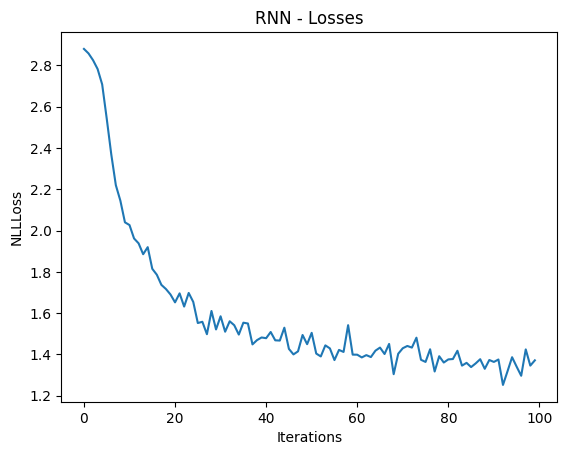

In [27]:
print_losses(rnn_losses, 'RNN - Losses')

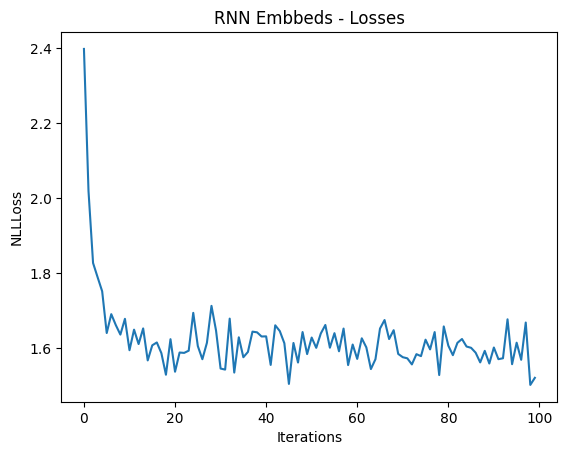

In [28]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

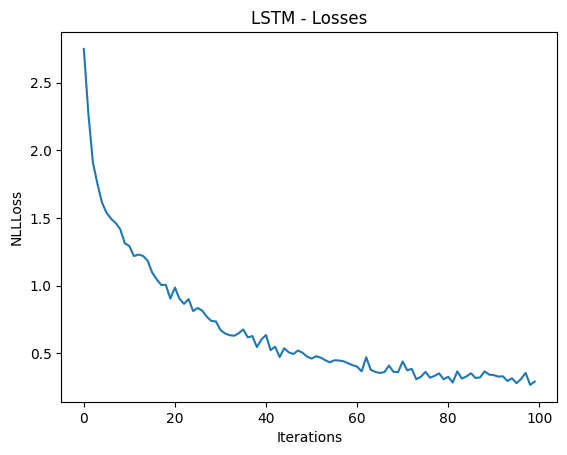

In [29]:
print_losses(lstm_losses, 'LSTM - Losses')

In [30]:
# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig, ax = plt.subplots(figsize=(20, 20))
  cax = ax.matshow(confusion)

  # Display values inside the cells
  for i in range(len(all_categories)):
      for j in range(len(all_categories)):
          ax.text(j, i, str(round(confusion[i, j].item(), 3)), va='center', ha='center', color='white')

  fig.colorbar(cax, shrink=0.8)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=45)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.xaxis.set_label_coords(0.5, -0.1)
  ax.xaxis.tick_bottom()
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.set_ticks_position("none")

  plt.title(f'Confusion Matrix of {model.__class__.__name__}')
  plt.show()

<ipython-input-30-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


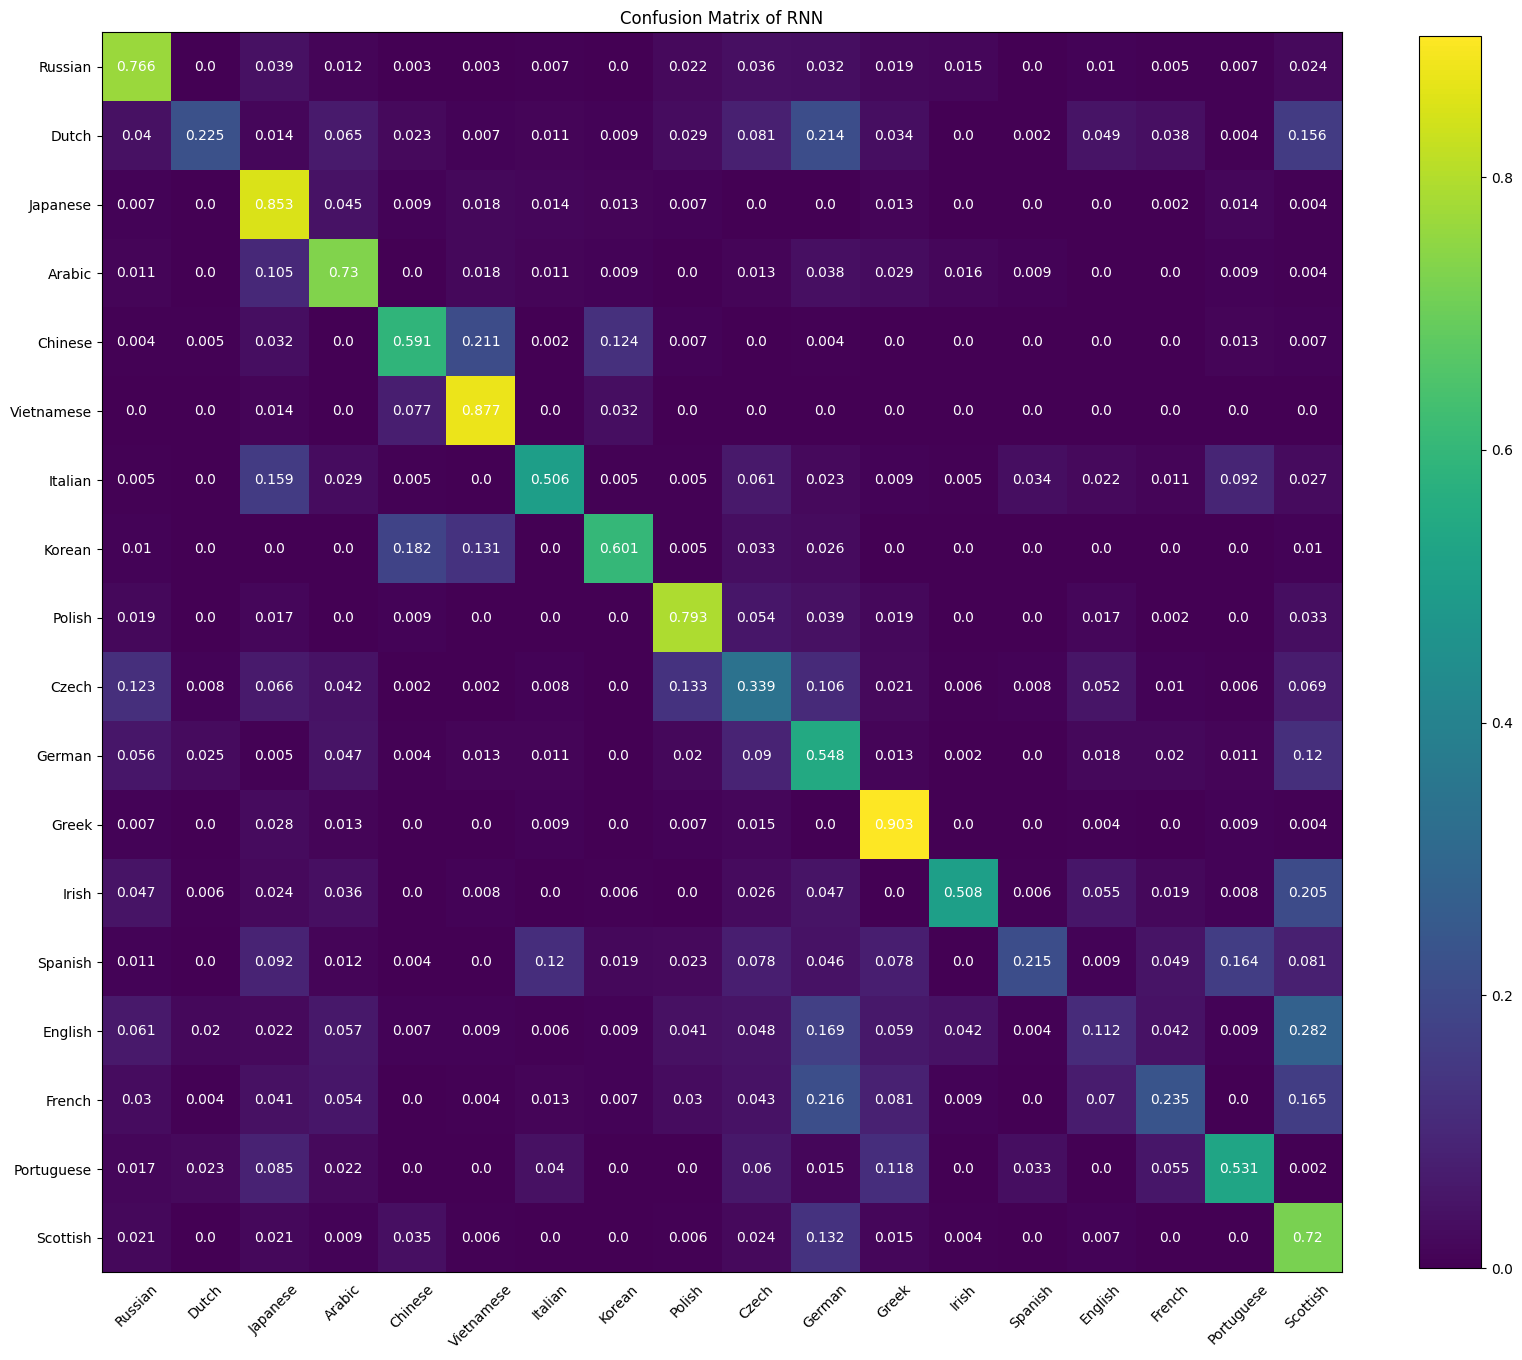

In [31]:
create_confusion_matrix(rnn)

<ipython-input-30-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


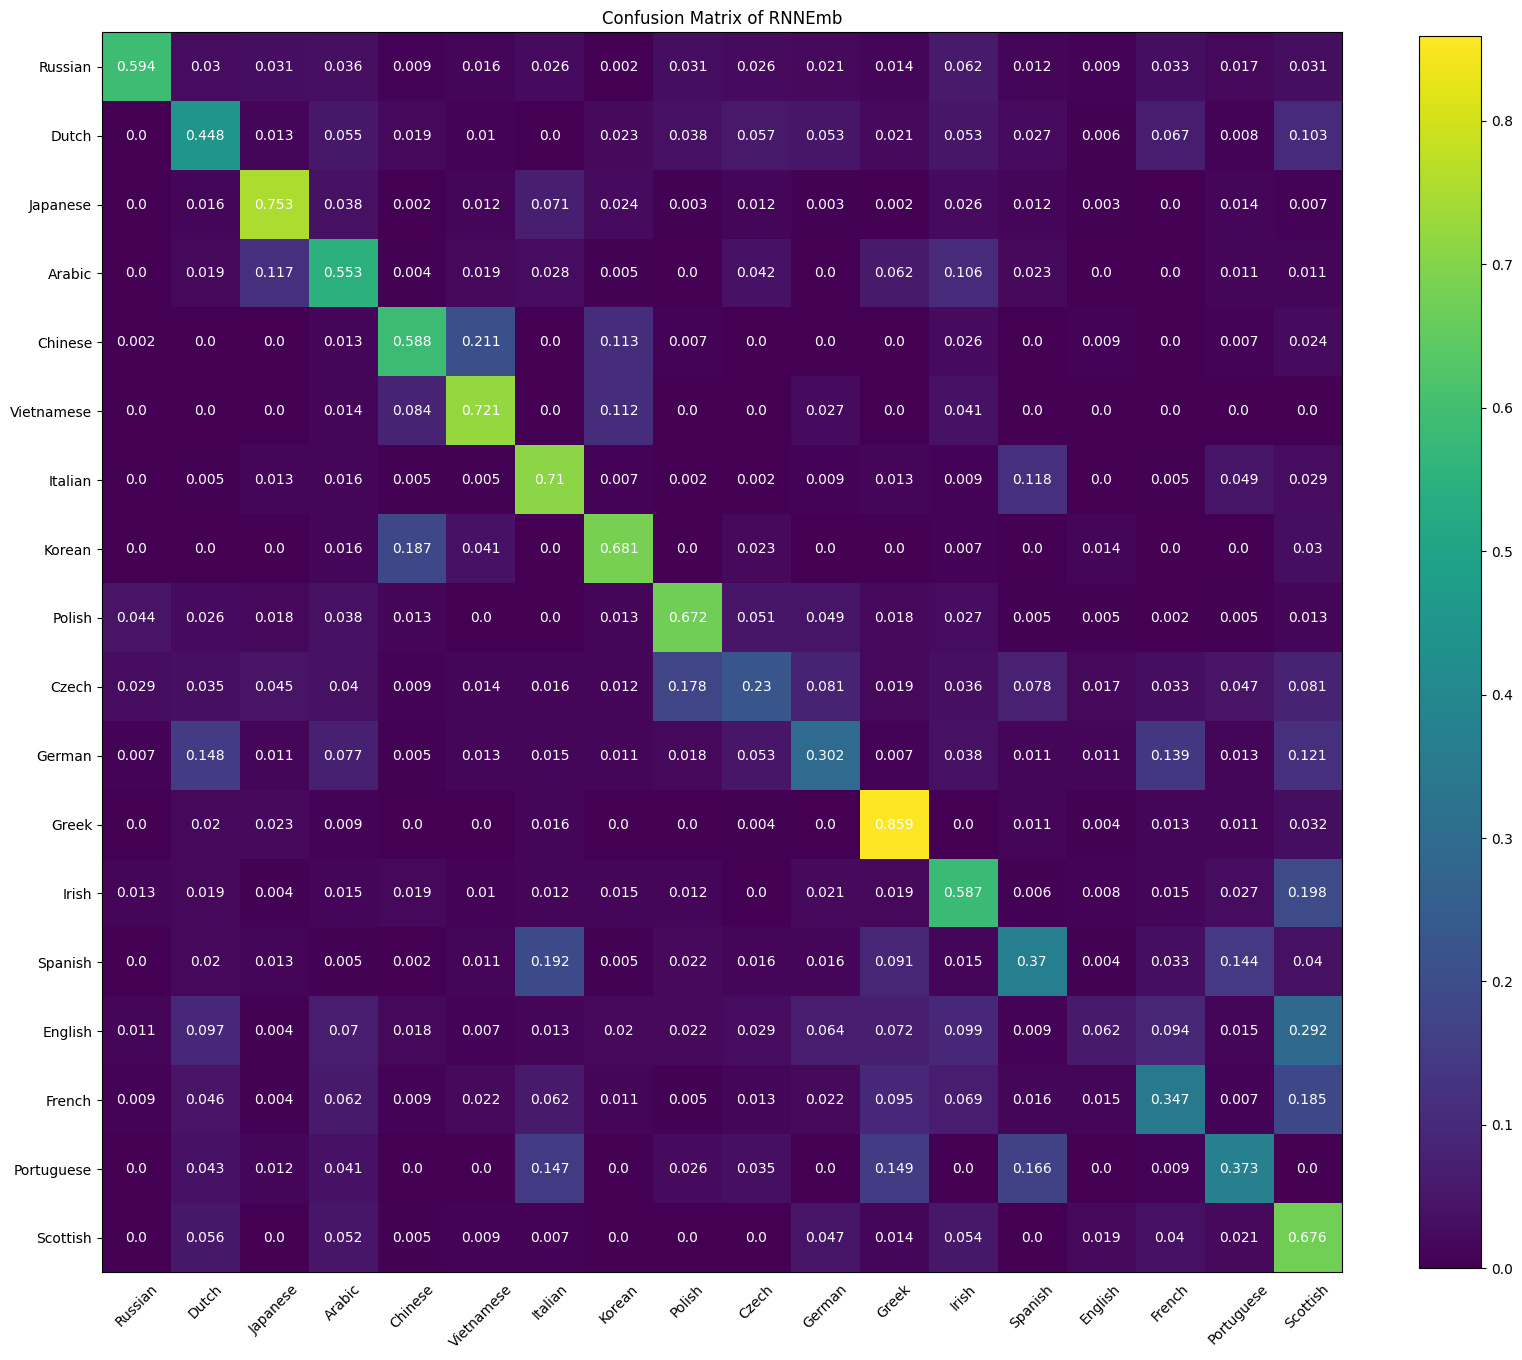

In [32]:
create_confusion_matrix(rnn_embeds)

<ipython-input-30-323fde681378>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=45)
<ipython-input-30-323fde681378>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


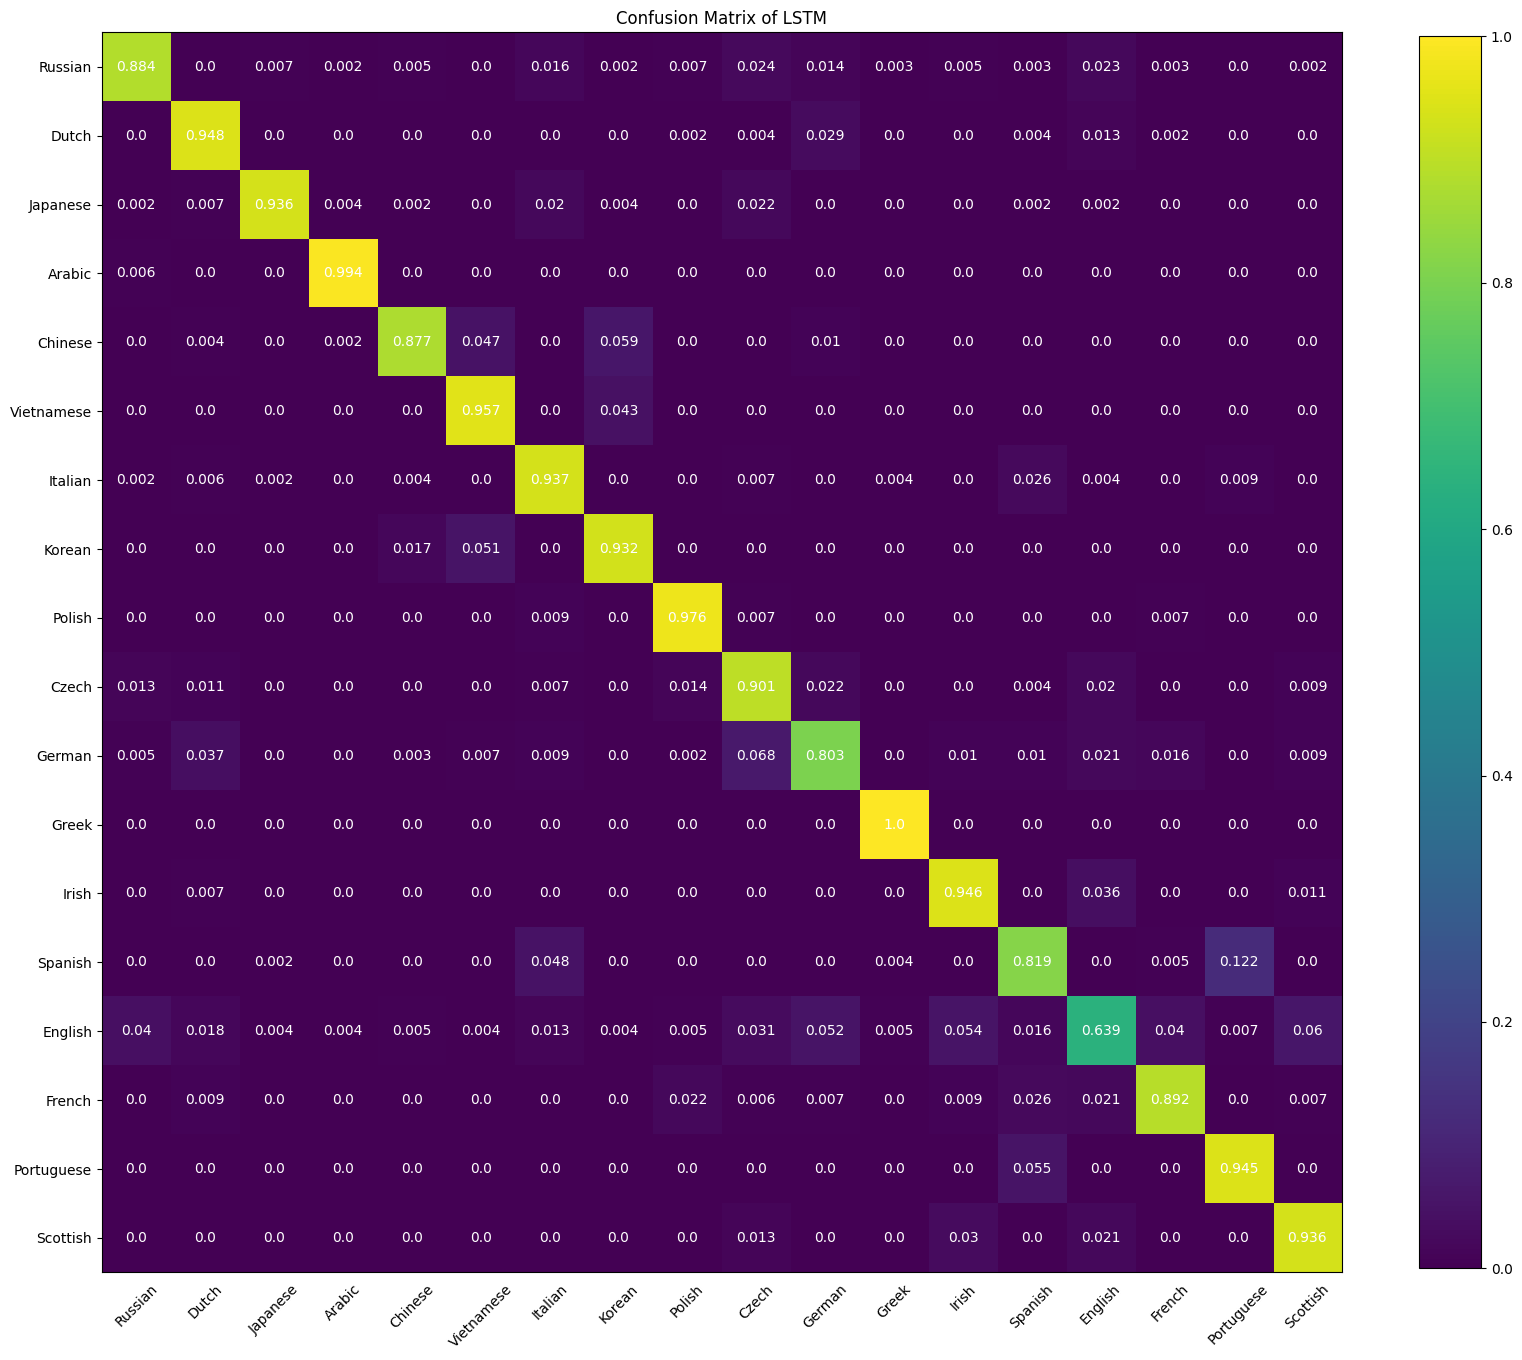

In [33]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [34]:
def getTrainingSample(word, model):
    # create a long tensor with the index of the language
    if model.type_layer == 'linear': return wordToOneHotTensor(word)
    else: return wordToEmbedding(word)

In [35]:
sourname_to_lang = {}

for lang, list_sournames in category_words.items():
  for sourname in list_sournames:
    sourname_to_lang[sourname] = lang

sournames, languages_sournames = list(sourname_to_lang.keys()), list(sourname_to_lang.values())

# sourname_to_lang -> dictionary of key: name, value: language
# sournames -> list of sournames derived from the dictionary keys
# languages_sourname -> list of languages derived from the dictionary values

# all three have the same indexes

In [36]:
def get_embeddings(model):

  embeddings = np.empty((0, 256)) if model.__class__.__name__ == 'LSTM' else np.empty((0,128))

  model.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  # Iterate over your dataset and extract hidden states
  for sourname in sournames:
      hidden = model.initHidden()

      tensor_sourname = getTrainingSample(sourname, model)

      for i in range(tensor_sourname.size(0)):

          with torch.no_grad():
            _, hidden = model(tensor_sourname[i], hidden)

      embeddings =  np.vstack((embeddings, torch.cat(hidden, dim = 1))) if model.__class__.__name__ == 'LSTM' else np.vstack((embeddings, hidden))

  return embeddings

In [37]:
def get_tsne_embeds(embeds, indices):
  embeds_tsne_indices = TSNE().fit_transform(embeds.squeeze()[indices,:])
  embeds_tsne_all = TSNE().fit_transform(embeds.squeeze())
  return embeds_tsne_indices, embeds_tsne_all

In [38]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


def print_embeddings(embeds_tsne_indices, indices, title):
    colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'blue', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

    fig, ax = plt.subplots(figsize=(12, 12))

    # Create an empty list to store unique legend entries
    legend_entries = []
    unique_languages = list(category_words.keys())

    for i, val in enumerate(indices):
        #color = colors[sournames.index(languages_sournames[val])]
        color = colors[unique_languages.index(languages_sournames[val])]

        # Check if the language is already in the legend_entries list
        if languages_sournames[val] not in legend_entries:
            # Add the language to legend_entries to avoid duplicates
            legend_entries.append(languages_sournames[val])
            plt.scatter(*embeds_tsne_indices[i, :], color=color, label=languages_sournames[val])
        else:
            # If the language is already in legend_entries, don't add a label
            plt.scatter(*embeds_tsne_indices[i, :], color=color)

    plt.title(title)

    # Display the legend with unique entries
    plt.legend()
    plt.show()

In [39]:
def get_embds_sim(embeddings):
  sim = cosine_similarity(embeddings)
  np.fill_diagonal(sim, -1.0)
  return sim

In [40]:
viz_words = 2000
indices = np.random.choice(len(sourname_to_lang), viz_words)

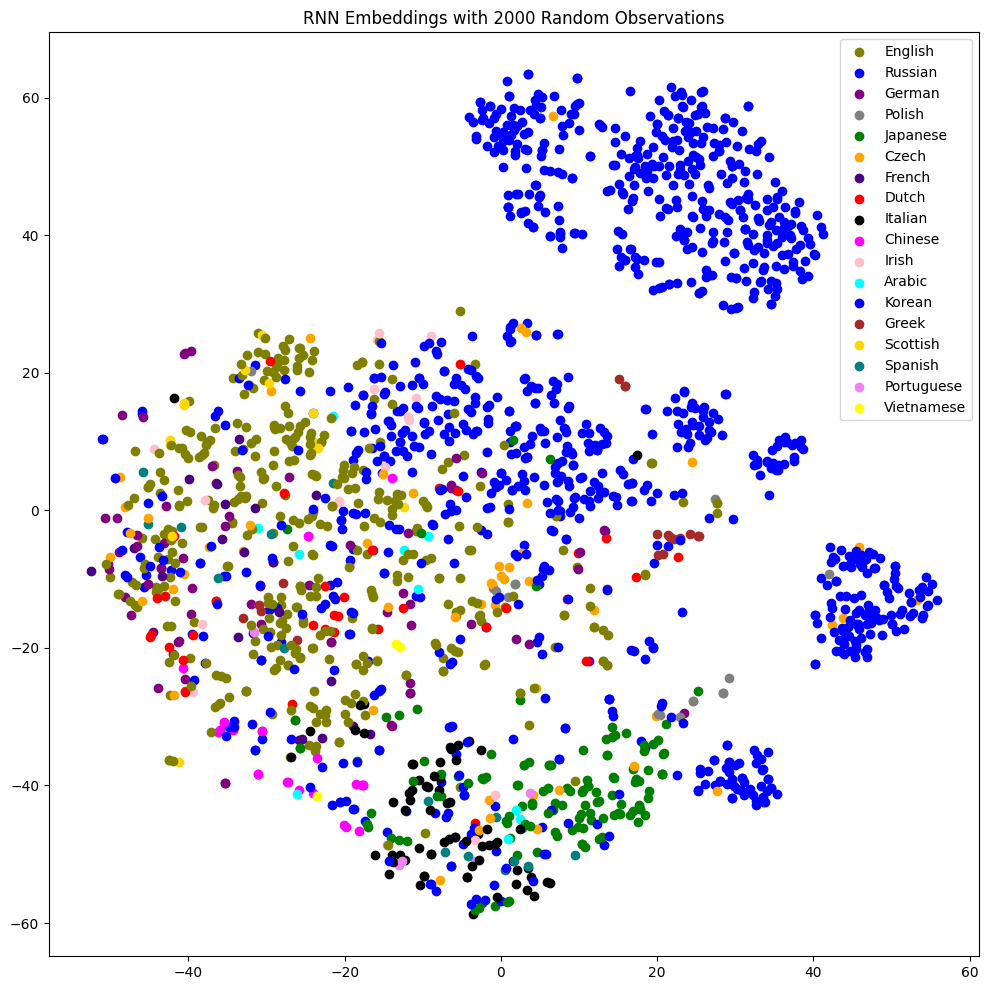

In [41]:
embeds_rnn = get_embeddings(rnn)
embeds_tsne_indices_rnn, embeds_tsne_all_rnn = get_tsne_embeds(embeds_rnn, indices)
print_embeddings(embeds_tsne_indices_rnn, indices, f'RNN Embeddings with {viz_words} Random Observations')
sim_rnn = get_embds_sim(embeds_rnn)

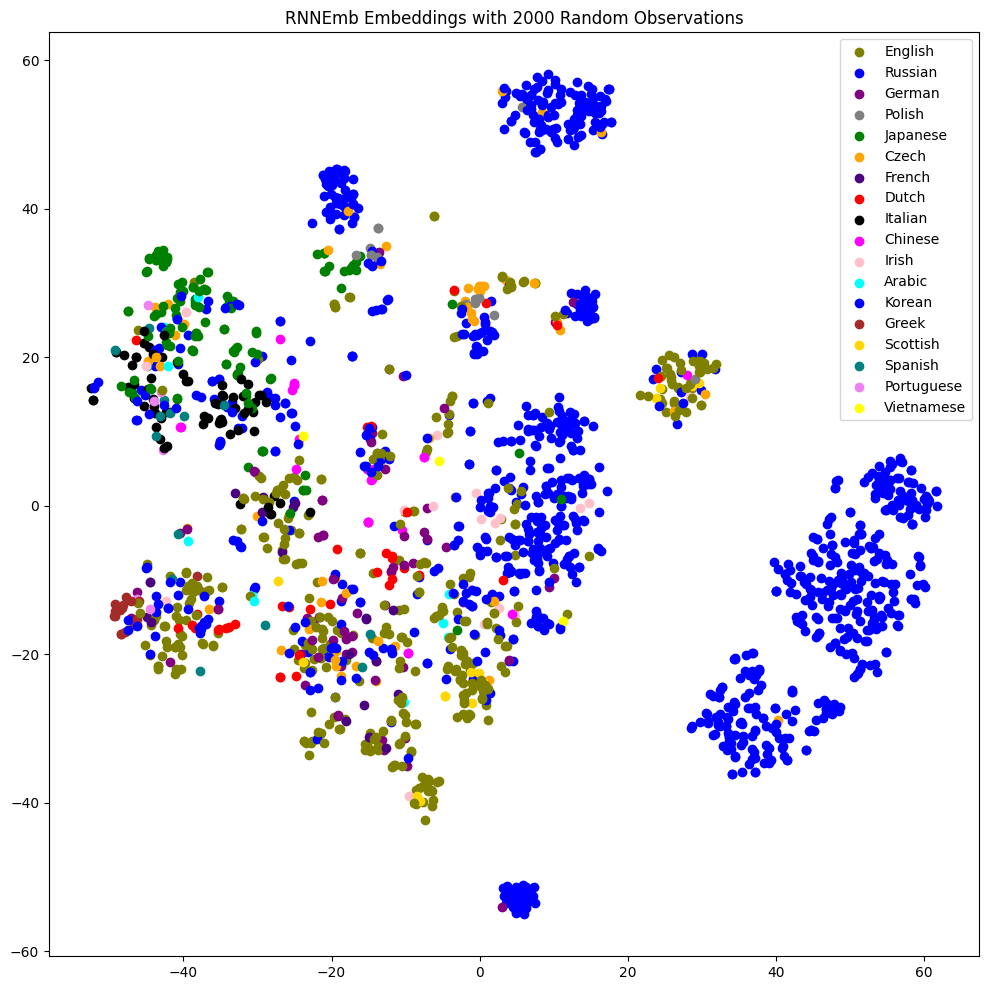

In [42]:
embeds_rnn_emb = get_embeddings(rnn_embeds)
embeds_tsne_indices_rnn_emb, embeds_tsne_all_rnn_emb = get_tsne_embeds(embeds_rnn_emb, indices)
print_embeddings(embeds_tsne_indices_rnn_emb, indices, f'RNNEmb Embeddings with {viz_words} Random Observations')
sim_rnn_emb = get_embds_sim(embeds_rnn_emb)

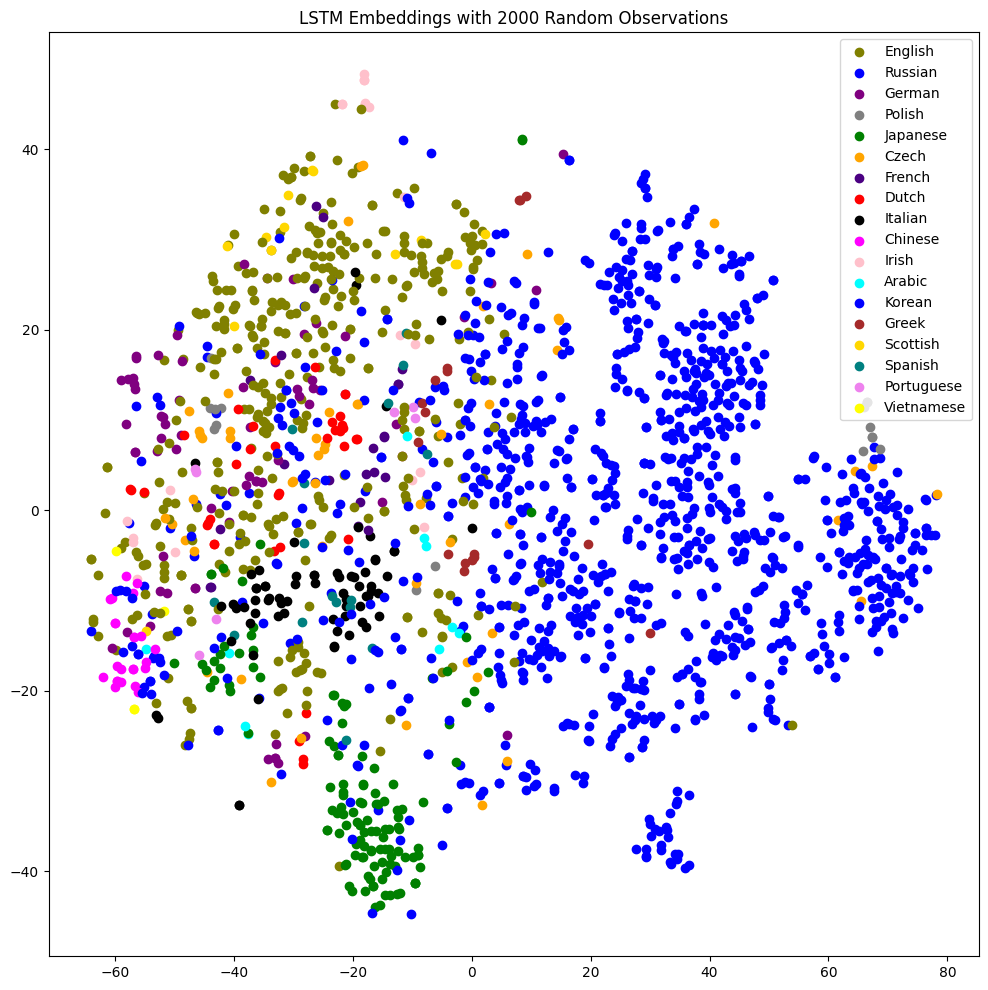

In [43]:
embeds_lstm = get_embeddings(lstm)
embeds_tsne_indices_lstm, embeds_tsne_all_lstm = get_tsne_embeds(embeds_lstm, indices)
print_embeddings(embeds_tsne_indices_lstm, indices, f'LSTM Embeddings with {viz_words} Random Observations')
sim_lstm = get_embds_sim(embeds_lstm)

In [66]:
def get_random_sournames_languages():
  list_idxs_lan_mat_sim = []
  for lang, sournames_list in category_words.items():
    rand_sourname = random.sample(sournames_list, 1)[0]

    list_idxs_lan_mat_sim.append((sournames.index(rand_sourname), languages_sournames[sournames.index(rand_sourname)]))

  return list_idxs_lan_mat_sim

list_idxs_lan_mat_sim = get_random_sournames_languages()

In [85]:
def get_names_similarity(list_idxs_lan_mat_sim, embs_sim, top_k):

  dict_to_return = {}

  for values in list_idxs_lan_mat_sim:

    idx_in_mat_sim, lang = values

    most_sim_sournames_idx = np.flip(np.argsort(embs_sim[idx_in_mat_sim]))[:top_k]
    most_sim_sournames_str = [sournames[idx] for idx in most_sim_sournames_idx]
    most_sim_sournames_lan = [languages_sournames[idx] for idx in most_sim_sournames_idx]
    most_similar_sournames_sim = [embs_sim[idx_in_mat_sim, idx] for idx in most_sim_sournames_idx]

    dict_to_return[idx_in_mat_sim] = (lang, most_sim_sournames_idx)

    print(f'Most similar name for "{sournames[idx_in_mat_sim]} - ({lang})" are:\t{most_sim_sournames_str}')
    print(f'With corresponding languages:\t{most_sim_sournames_lan}')
    print(f'With corresponding indices:\t{most_sim_sournames_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_sournames_sim}\n')

  return dict_to_return

In [86]:
# set the top-k names to see for a random name for each language
top_k = 30

In [87]:
dict_sim_rnn = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn, top_k)

Most similar name for "Makushev - (Russian)" are:	['Makyshev', 'Jakushev', 'Yakushev', 'Chikishev', 'Utyashev', 'Makhtiev', 'Yakushov', 'Jakushov', 'Vikhorev', 'Atyashev', 'Bekyashev', 'Markushev', 'Mokrushev', 'Nakhushev', 'Atyushov', 'Emyashev', 'Jikharev', 'Bakhtiev', 'Vikhirev', 'Mikhilev', 'Egishev', 'Shakhmaev', 'Minyushev', 'Mikhalev', 'Martyushev', 'Shakhpaev', 'Maryshev', 'Vikharev', 'Gladyshev', 'Likharev']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[5335 4147 8682 2003 7970 5301 8687 4152 8354  696 1686 5358 5735 5979
  700 2699 4410 1365 8351 5569 2607 7143 5636 5548 5403 7159 5428 8349
 3062 5013]
With corresponding Embedding Cosine 

In [88]:
dict_sim_rnn_emb = get_names_similarity(list_idxs_lan_mat_sim, sim_rnn_emb, top_k)

Most similar name for "Makushev - (Russian)" are:	['Yakushev', 'Markushev', 'Minyushev', 'Makyshev', 'Chikishev', 'Chamushev', 'Deryushev', 'Mokrushev', 'Omashev', 'Jakushev', 'Nakhushev', 'Maksheev', 'Nahushev', 'Demishev', 'Turushev', 'Sheludshev', 'Maryshev', 'Cheryshev', 'Maryashev', 'Tugushev', 'Yepishev', 'Paidyshev', 'Nuryshev', 'Martyushev', 'Chanyshev', 'Tchamushev', 'Timashev', 'Adashev', 'Yakushov', 'Vandyshev']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[8682 5358 5636 5335 2003 1884 2242 5735 6152 4147 5979 5305 5970 2212
 7823 7246 5428 1989 5423 7707 8778 6232 6115 5403 1889 7355 7464  254
 8687 8149]
With corresponding Embedding C

In [89]:
dict_sim_lstm = get_names_similarity(list_idxs_lan_mat_sim, sim_lstm, top_k)

Most similar name for "Makushev - (Russian)" are:	['Yakushev', 'Egishev', 'Emyashev', 'Makusev', 'Chikishev', 'Jakushev', 'Minyushev', 'Makyshev', 'Omashev', 'Maksheev', 'Mikheev', 'Yakimychev', 'Utyashev', 'Maksimychev', 'Jakimychev', 'Nakhushev', 'Churuksaev', 'Atyashev', 'Mukaseev', 'Maryashev', 'Emyshev', 'Mokrushev', 'Kabyshev', 'Trukhachev', 'Jakhaev', 'Muzhkaterov', 'Yakushov', 'Makaseev', 'Chikhachev', 'Mukusev']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[8682 2607 2699 5331 2003 4147 5636 5335 6152 5305 5562 8645 7970 5314
 4112 5979 2066  696 5872 5423 2700 5735 4666 7574 4096 5947 8687 5269
 1998 5883]
With corresponding Embedding Cos

In [90]:
import seaborn as sns

def plot_point_features(xy_tsne, dictionary, title):
  x = xy_tsne[:,0]
  y = xy_tsne[:,1]


  plt.figure(figsize=(20, 20))
  plot = sns.scatterplot(x=x, y=y)

  list_colors = ['darkblue', 'orange', 'green', 'mediumturquoise', 'darkmagenta', 'khaki', 'dimgray', 'royalblue', 'darkslategray', 'coral', 'mediumorchid', 'saddlebrown', 'lightpink', 'mediumseagreen', 'olivedrab', 'slategray', 'mediumvioletred', 'darkgoldenrod']
  j = 0

  for target_index, (lang, list_idx_sournames) in dictionary.items():

      plot.text(x[target_index], y[target_index], sournames[target_index], horizontalalignment='center', size='small', color='black', weight='semibold')
      plt.scatter(x[target_index], y[target_index], marker='o', color=list_colors[j])

      top_similar_x = [x[i] for i in list_idx_sournames]
      top_similar_y = [y[i] for i in list_idx_sournames]

      plt.scatter(top_similar_x, top_similar_y, marker='o', color=list_colors[j], label=f'Similar to {sournames[target_index]} ({lang})')

      j += 1

  plt.title(title)
  plt.legend()
  plt.show()

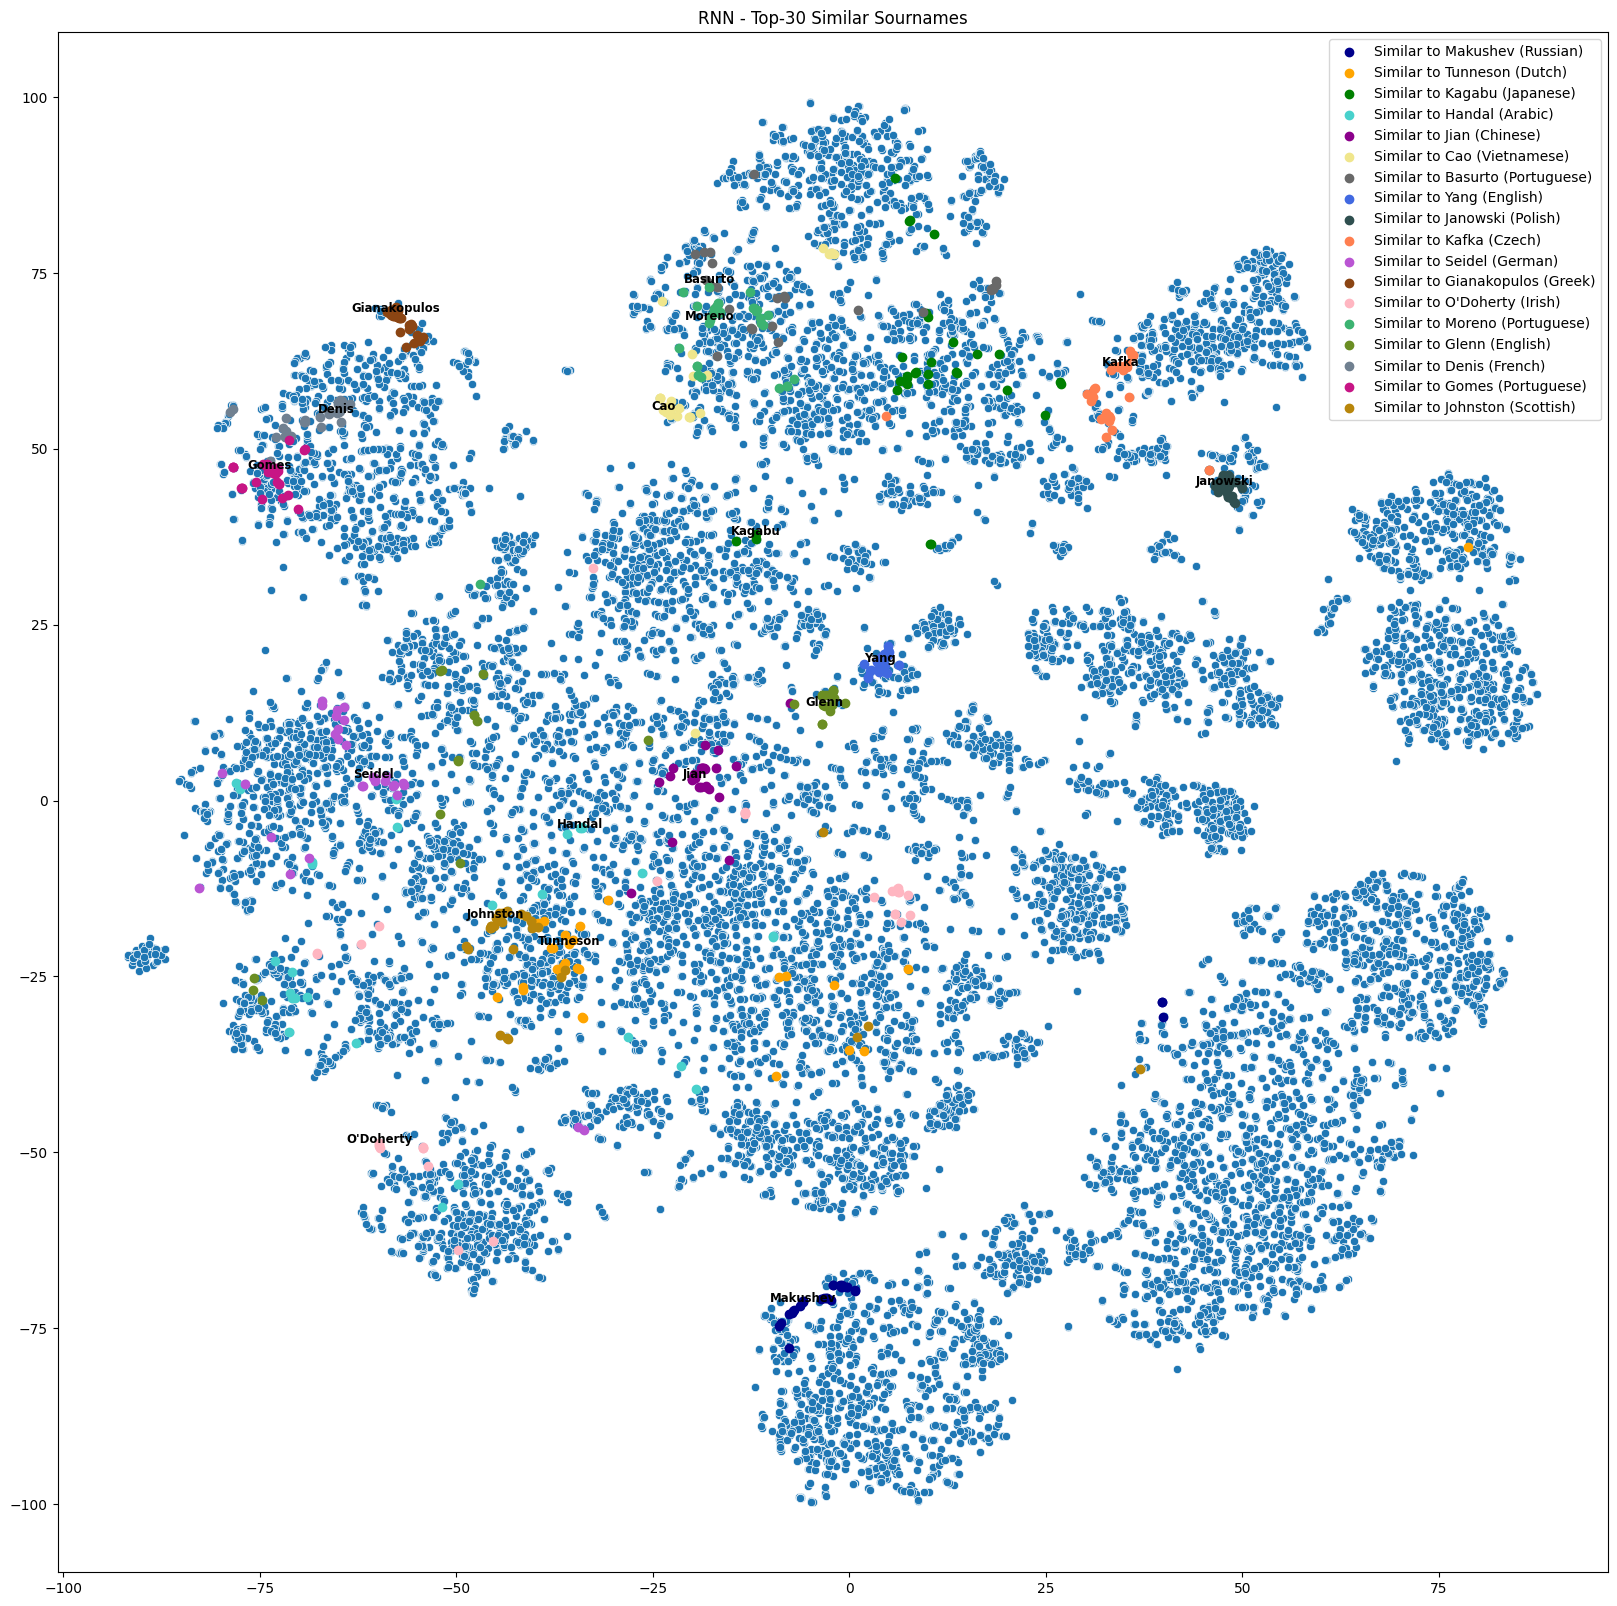

In [91]:
plot_point_features(embeds_tsne_all_rnn, dict_sim_rnn, f'RNN - Top-{top_k} Similar Sournames')

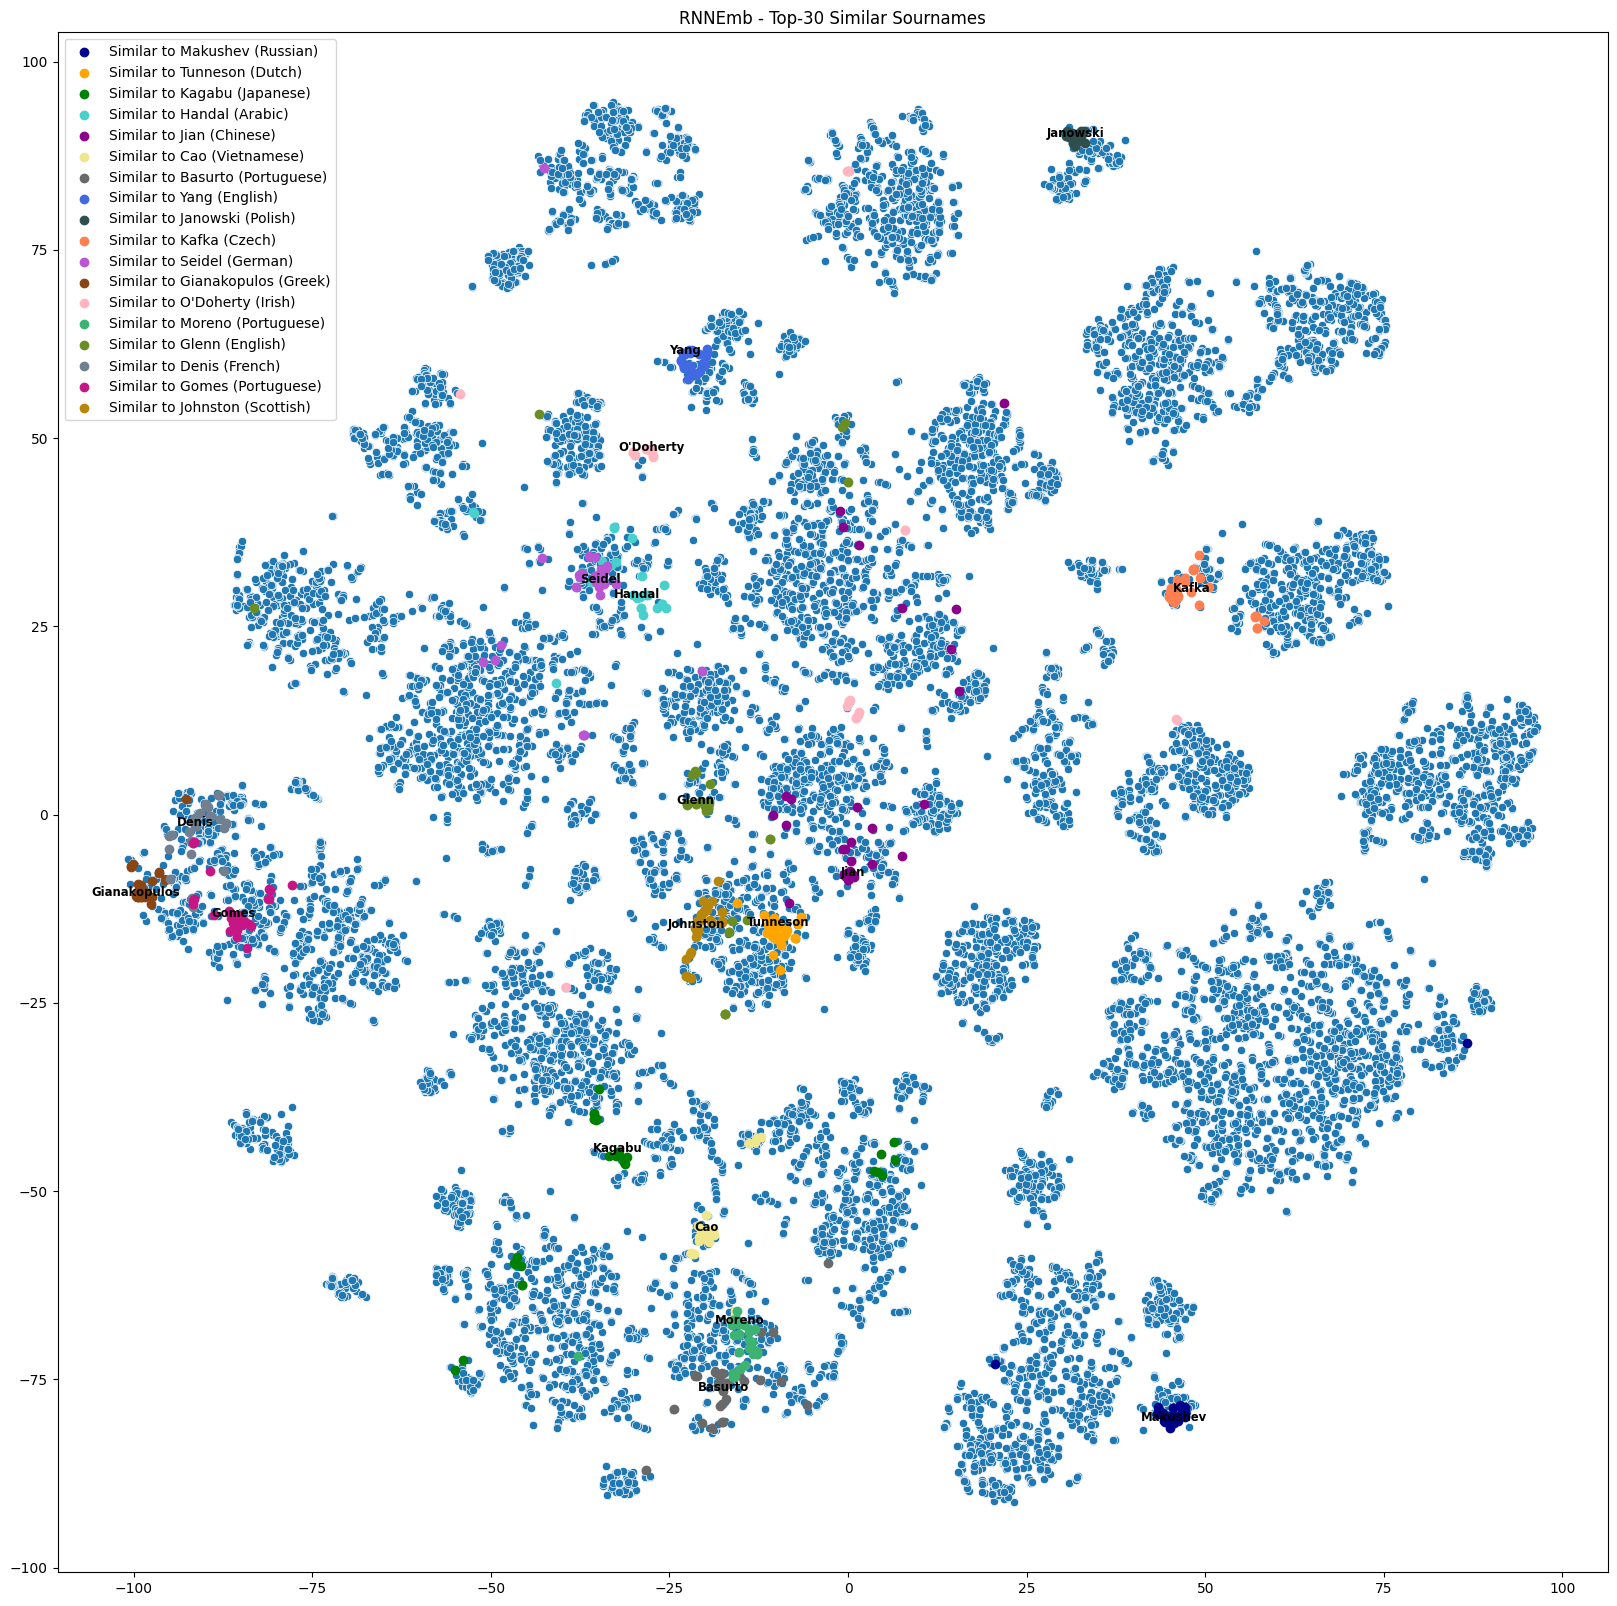

In [92]:
plot_point_features(embeds_tsne_all_rnn_emb, dict_sim_rnn_emb, f'RNNEmb - Top-{top_k} Similar Sournames')

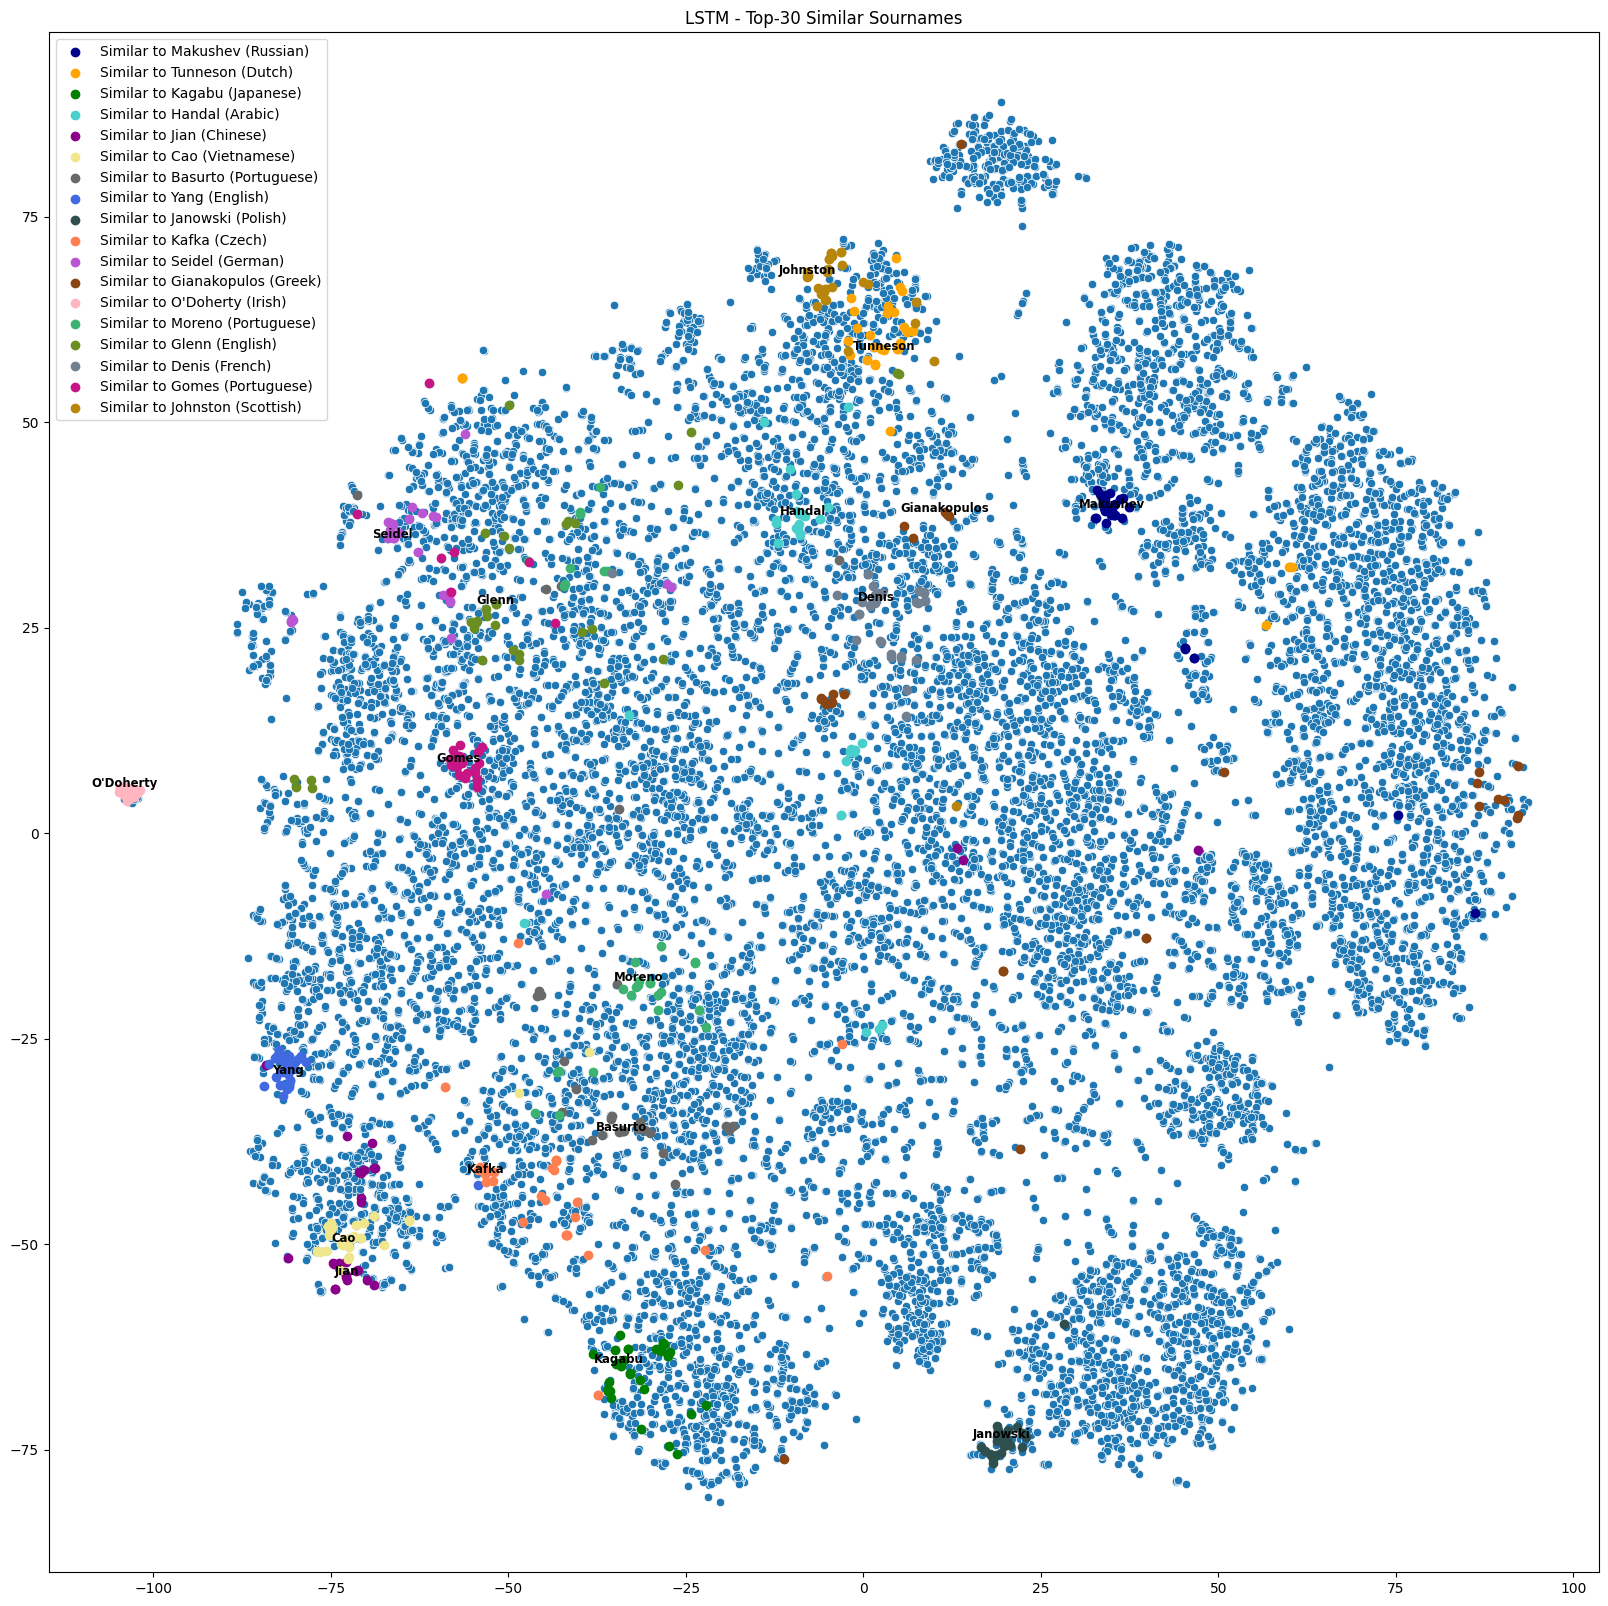

In [93]:
plot_point_features(embeds_tsne_all_lstm, dict_sim_lstm, f'LSTM - Top-{top_k} Similar Sournames')